In [1]:
from pathlib import Path


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_TFiso1_collection,
                          load_disorder_predictions,
                          load_ref_vs_alt_isoforms_table)
from data_loading import (load_y2h_isoform_data, 
load_y1h_pdi_data, 
load_valid_isoform_clones)

In [2]:
df = load_disorder_predictions()
# lazy version: delta disordered residues
# for each isoform: number of residues, disordered residues and ordered residues
# for each pair, delta of all
n_aa = df.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = df.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']

pairs = load_ref_vs_alt_isoforms_table()
pairs['clone_name_ref'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['clone_name_alt'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

for c in n_aa.columns:
    pairs[f'delta_{c}'] = pairs['clone_name_ref'].map(n_aa[c]) - pairs['clone_name_alt'].map(n_aa[c])
    pairs[f'abs_delta_{c}'] = pairs[f'delta_{c}'].abs()

In [3]:
df['secondary_structure'].value_counts()

-    151527
H     75987
T     20315
E     17677
S     15462
G      4997
B       910
I       682
Name: secondary_structure, dtype: int64

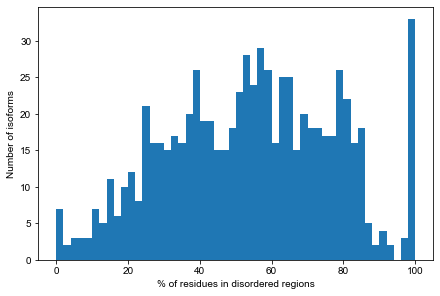

In [4]:
fig, ax = plt.subplots(1, 1)
f_dis = df.groupby('clone_name')['is_disordered'].mean()
(f_dis * 100).plot.hist(range=(0, 100), bins=50, ax=ax)
ax.set_ylabel('Number of isoforms')
ax.set_xlabel('% of residues in disordered regions')
fig.savefig('../figures/disordered-residued-pct-per-isoform_TFiso1_histogram.pdf', 
    bbox_inches='tight')

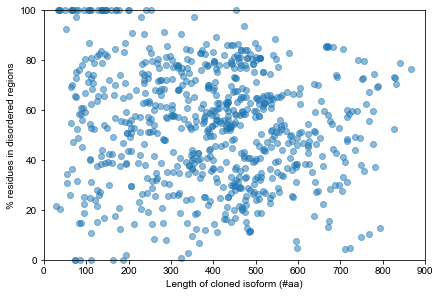

In [5]:
# TODO: color by family
# TODO: split by reference and alternative isoforms
fig, ax = plt.subplots(1, 1)
ax.scatter(df.groupby('clone_name').size(), 
           df.groupby('clone_name')['is_disordered'].mean() * 100,
           clip_on=False,
           alpha=0.5)
ax.set_ylim(0, 100)
ax.set_xlim(0, 900)
ax.set_xlabel('Length of cloned isoform (#aa)')
ax.set_ylabel('% residues in disordered regions')
fig.savefig('../figures/disordered-residued-pct-per-isoform-vs-length_TFiso1_scatter.pdf', 
    bbox_inches='tight')

In [6]:
# plots of length of disordered sequence?

In [7]:
# comparison of reference to alternative isoforms


In [8]:
# pairwise metrics of disorder/order
# - number of ordered residues different
# - number of disordered residues different


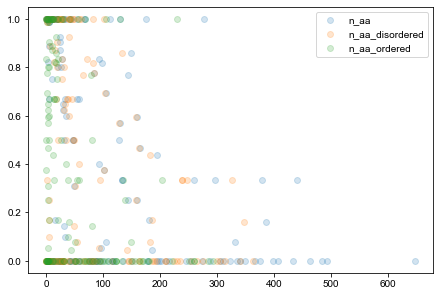

In [9]:
fig, ax = plt.subplots(1, 1)
y = 'PPI_jaccard'
for c in n_aa.columns:
    x = f'abs_delta_{c}'
    ax.scatter(pairs.loc[pairs[x].notnull() & pairs[y].notnull(), x],
            pairs.loc[pairs[x].notnull() & pairs[y].notnull(), y],
            alpha=0.2,
            label=c)
ax.legend()

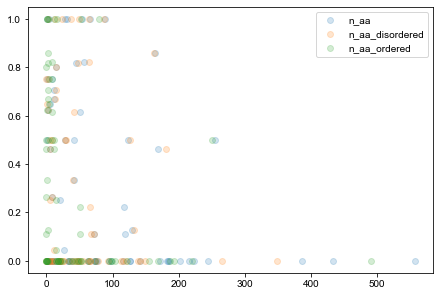

In [10]:
fig, ax = plt.subplots(1, 1)
y = 'PDI_jaccard'
for c in n_aa.columns:
    x = f'abs_delta_{c}'
    ax.scatter(pairs.loc[pairs[x].notnull() & pairs[y].notnull(), x],
            pairs.loc[pairs[x].notnull() & pairs[y].notnull(), y],
            alpha=0.2,
            label=c)
ax.legend()

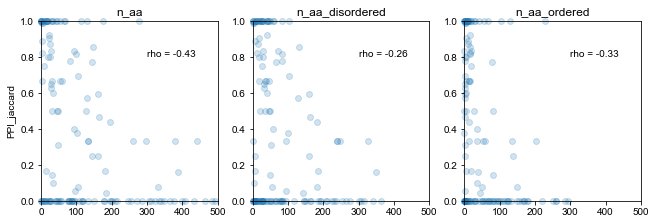

In [11]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(h=3, w=9)
y_col = 'PPI_jaccard'
axs[0].set_ylabel(y_col)
for c, ax in zip(n_aa.columns, axs):
    x_col = f'abs_delta_{c}'
    x = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), x_col]
    y = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), y_col]
    ax.scatter(x, y, alpha=0.2, label=c, clip_on=False)
    ax.set_title(c)
    ax.text(x=300, y=0.8, s=f'rho = {stats.spearmanr(x, y)[0]:.2f}')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 500)
fig.savefig('../figures/test2_scatter_disorder.pdf')

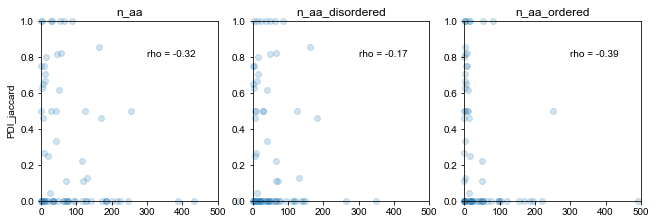

In [12]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(h=3, w=9)
y_col = 'PDI_jaccard'
axs[0].set_ylabel(y_col)
for c, ax in zip(n_aa.columns, axs):
    x_col = f'abs_delta_{c}'
    x = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), x_col]
    y = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), y_col]
    ax.scatter(x, y, alpha=0.2, label=c, clip_on=False)
    ax.set_title(c)
    ax.text(x=300, y=0.8, s=f'rho = {stats.spearmanr(x, y)[0]:.2f}')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 500)
fig.savefig('../figures/test3_scatter_disorder.pdf')

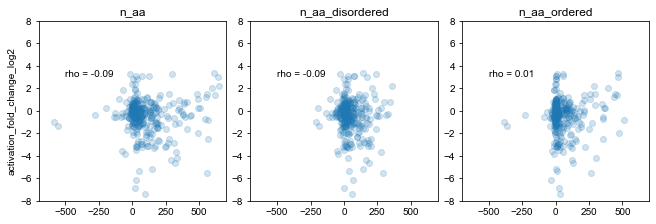

In [13]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(h=3, w=9)
y_col = 'activation_fold_change_log2'
axs[0].set_ylabel(y_col)
for c, ax in zip(n_aa.columns, axs):
    x_col = f'delta_{c}'
    x = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), x_col]
    y = pairs.loc[pairs[x_col].notnull() & pairs[y_col].notnull(), y_col]
    ax.scatter(x, y, alpha=0.2, label=c)
    ax.set_title(c)
    ax.text(x=-500, y=3, s=f'rho = {stats.spearmanr(x, y)[0]:.2f}')
    ax.set_ylim(-8, 8)
    ax.set_xlim(-700, 700)
fig.savefig('../figures/test_scatter_disorder.pdf')

In [14]:
n_aa.loc[n_aa['n_aa_ordered'] == 0].sort_values('n_aa_disordered', ascending=False)

,n_aa,n_aa_disordered,n_aa_ordered
clone_name,,,
FOXO3-2,453,453,0
PLAGL1-2,252,252,0
NFAT5-1,242,242,0
SALL2-3,200,200,0
SALL2-2,198,198,0
SPIB-1,178,178,0
FOS-3,170,170,0
SP2-5,170,170,0
ZNF280D-2,158,158,0


In [15]:
f_dis.sort_values()

clone_name
ZBTB25-4    0.0
KLF7-6      0.0
TBPL1-2     0.0
TBPL1-1     0.0
ZNF415-4    0.0
           ... 
ZNF175-3    1.0
ZNF696-2    1.0
SALL2-2     1.0
FOXO3-2     1.0
SP2-5       1.0
Name: is_disordered, Length: 742, dtype: float64

In [16]:
m1h = load_m1h_activation_data()
tfs = load_annotated_TFiso1_collection()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)

df = load_ref_vs_alt_isoforms_table()   # TODO: remove this duplication
df['ref_iso'] = df['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['alt_iso'] = df['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['f_disorder_difference'] = df.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)


def disorder_changes_category(f):
    if pd.isnull(f):
        return np.nan
    elif f == 0:
        return 'fully ordered'
    elif f == 1:
        return 'fully disordered'
    elif f > 0 and f < 1:
        return 'partially disordered'
    else:
        raise ValueError('Invalid fraction')


df['f_disorder_difference_cat'] = df['f_disorder_difference'].apply(disorder_changes_category)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
df['m1h_gte_2_fold_at_least_one_iso_per_gene'] = df['gene_symbol'].map(m1h.groupby('gene_symbol')
                                                                    ['gte_2_fold']
                                                                    .any())
df['abs_activation_fold_change_log2'] = df['activation_fold_change_log2'].abs()

dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
dom = dom.loc[dom['category'] == 'effector_domain', :]

# add activation or repression
info = pd.read_excel('../data/external/Soto-et-al_MolCell_2022_Supplementary-tables.xlsx',
                     sheet_name="Table S2")
if info['Effector domain ID'].duplicated().any():
    raise UserWarning('unexpected duplicates')
info = info.set_index('Effector domain ID')
dom['type'] = dom['accession'].map(info['Domain type'])


def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)

reading from cache


In [17]:
from data_loading import load_tf_families, load_human_tf_db, load_y2h_isoform_data

y2h = load_y2h_isoform_data()
tfdb = load_human_tf_db()
y2h["is_tf_tf_ppi"] = y2h["db_gene_symbol"].isin(tfdb["HGNC symbol"].unique())

# of reference dimer PPI, are all lost, some lost, none lost
def ppi_pertubation(row, ppi):
    ref_clone_acc = row["clone_acc_ref"]
    alt_clone_acc = row["clone_acc_alt"]
    if (
        ref_clone_acc not in ppi["ad_clone_acc"].unique()
        or alt_clone_acc not in ppi["ad_clone_acc"].unique()
    ):
        return np.nan
    df = (
        ppi.loc[
            ppi["ad_clone_acc"].isin([ref_clone_acc, alt_clone_acc]),
            ["ad_clone_acc", "db_gene_symbol", "Y2H_result"],
        ]
        .pivot(values="Y2H_result", index="db_gene_symbol", columns="ad_clone_acc")
        .dropna()
    )
    df = df.loc[df.any(axis=1), :]
    if df.shape[0] == 0:
        return np.nan
    if df.all().all():
        return "retains all"
    elif not df[alt_clone_acc].any():
        return "loses all"
    elif df[alt_clone_acc].sum() > df[ref_clone_acc].sum():
        return "gains some"
    else:
        return "loses some"


df["other_than_tf_tf_ppi"] = df.apply(
    ppi_pertubation, ppi=y2h.loc[~y2h["is_tf_tf_ppi"], :], axis=1
)

In [18]:
# add other-than-tf category
def tf_tf_vs_other_ppi_cat(row):
    if (pd.isnull(row['n_positive_PPI_ref']) or
        pd.isnull(row['n_positive_PPI_alt']) or
        (row['n_positive_PPI_ref'] == 0) or
        (row['n_positive_PPI_alt'] == 0) or
        pd.isnull(row['tf_tf_ppi'])  or
        pd.isnull(row['other_than_tf_tf_ppi'])
        ):
       return np.nan
    elif row['tf_tf_ppi'] == 'retains all':
        if row['other_than_tf_tf_ppi'] == 'retains all':
            return 'No PPI change'
        else:
            return 'non-TF-TF PPI change'
    else:
        if row['other_than_tf_tf_ppi'] == 'retains all':
            return 'TF-TF PPI change'
        else:
            return 'TF-TF and other PPIs change'
    

df['tf_tf_vs_other_ppi_cat'] = df.apply(tf_tf_vs_other_ppi_cat, axis=1)

In [19]:
def tf_dimer_vs_other_ppi_cat(row):
    if (pd.isnull(row['n_positive_PPI_ref']) or
        pd.isnull(row['n_positive_PPI_alt']) or
        (row['n_positive_PPI_ref'] == 0) or
        (row['n_positive_PPI_alt'] == 0) or
        pd.isnull(row['dimer_ppi'])  or
        pd.isnull(row['other_than_dimer_ppi'])
        ):
       return np.nan
    elif row['dimer_ppi'] == 'retains all':
        if row['other_than_dimer_ppi'] == 'retains all':
            return 'No PPI change'
        else:
            return 'non-dimerizing PPI change'
    else:
        if row['other_than_dimer_ppi'] == 'retains all':
            return 'dimer PPI change'
        else:
            return 'dimer and other PPIs change'
    

df['dimer_vs_other_ppi_cat'] = df.apply(tf_dimer_vs_other_ppi_cat, axis=1)

Text(0.5, 0, '')

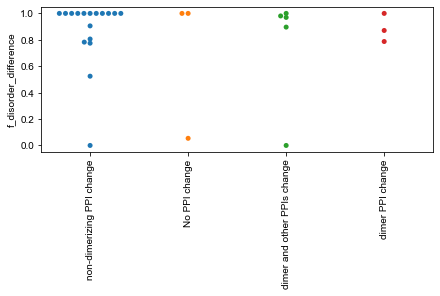

In [20]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df, x='dimer_vs_other_ppi_cat', y='f_disorder_difference', ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, '')

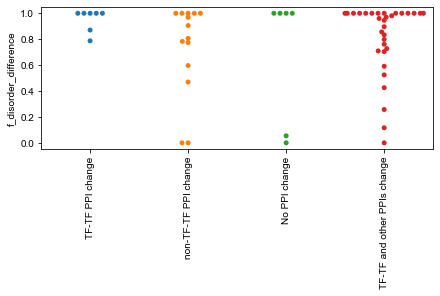

In [21]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df, x='tf_tf_vs_other_ppi_cat', y='f_disorder_difference', ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')

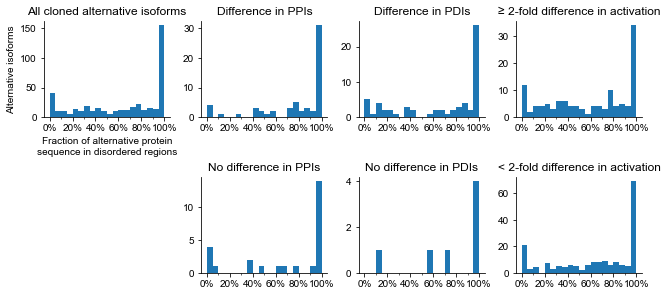

In [22]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(w=9, h=4)
n_bins=20
axs[0, 0].hist(df['f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 0].set_title('All cloned alternative isoforms')

axs[0, 1].hist(df.loc[(df['PPI_jaccard'] < 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 1].set_title('Difference in PPIs')


axs[1, 1].hist(df.loc[(df['PPI_jaccard'] == 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[1, 1].set_title('No difference in PPIs')


axs[0, 2].hist(df.loc[(df['PDI_jaccard'] < 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 2].set_title('Difference in PDIs')

axs[1, 2].hist(df.loc[(df['PDI_jaccard'] == 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[1, 2].set_title('No difference in PDIs')

axs[0, 3].hist(df.loc[(df['abs_activation_fold_change_log2'] >= 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[0, 3].set_title('≥ 2-fold difference in activation')

axs[1, 3].hist(df.loc[(df['abs_activation_fold_change_log2'] < 1),
        'f_disorder_difference'].values,
        range=(0, 1),
        bins=n_bins)
axs[1, 3].set_title('< 2-fold difference in activation')

for ax in axs.flatten():
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    ax.set_xticks(np.linspace(0, 1, 6))
    ax.set_xticks(np.linspace(0, 1, 11), minor=True)
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])    

axs[1, 0].axis('off')
axs[0, 0].set_ylabel('Alternative isoforms')
axs[0, 0].set_xlabel('Fraction of alternative protein\nsequence in disordered regions')
fig.savefig('../figures/disorder-pct-of-changes-vs-assay-differences_hist.pdf', bbox_inches='tight')

In [23]:
# TODO: move to plotting, reverse monkeypatch after plotting
# monkeypatch from https://github.com/mwaskom/seaborn/issues/525
fit_kde_func = sns.categorical._ViolinPlotter.fit_kde

def reflected_once_kde(self, x, bw):
    lb=0
    ub=1

    kde, bw_used = fit_kde_func(self, x, bw)

    kde_evaluate = kde.evaluate

    def truncated_kde_evaluate(x):
        val = np.where((x>=lb)&(x<=ub), kde_evaluate(x), 0)
        val += np.where((x>=lb)&(x<=ub), kde_evaluate(lb-x), 0)
        val += np.where((x>lb)&(x<=ub), kde_evaluate(ub-(x-ub)), 0)
        return val

    kde.evaluate = truncated_kde_evaluate
    return kde, bw_used

sns.categorical._ViolinPlotter.fit_kde = reflected_once_kde

<AxesSubplot: >

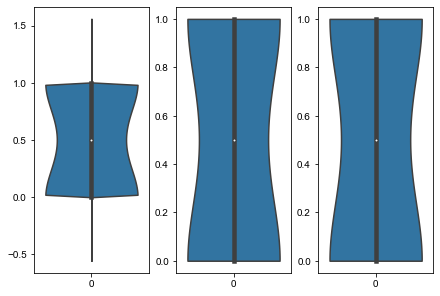

In [24]:
# TEST violin plot on bounded data
fig, axs = plt.subplots(1, 3)
data = [0, 0, 0, 0.5, 0.5, 0.5, 1, 1, 1]
sns.violinplot(data=data,
               ax=axs[0])
sns.violinplot(data=data,
               ax=axs[1],
               cut=0)
sns.violinplot(data=data,
               ax=axs[2],
               cut=0)

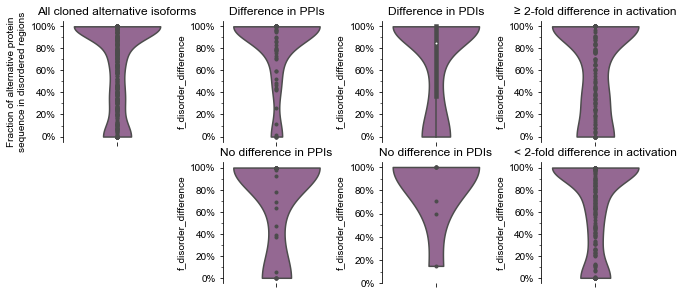

In [25]:
# add violin plot
from plotting import COLOR_PURPLE

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(w=9, h=4)
n_bins=20
sns.violinplot(data=df,
              y='f_disorder_difference',
                     inner='point',
       color=COLOR_PURPLE,
              ax=axs[0, 0],
              clip_on=False,
               cut=0,
             alpha=0.5  # TMP - to check no overlap
              )
axs[0, 0].set_title('All cloned alternative isoforms')

sns.violinplot(data=df.loc[(df['PPI_jaccard'] < 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
                   :],
              y='f_disorder_difference',
                  inner='point',
          color=COLOR_PURPLE,
              ax=axs[0, 1],
              clip_on=False,
               cut=0,
            alpha=0.5  # TMP - to check no overlap
              )
axs[0, 1].set_title('Difference in PPIs')

sns.violinplot(data=df.loc[(df['PPI_jaccard'] == 1) & 
                   (df['n_positive_PPI_ref'] > 0) &
                   (df['n_positive_PPI_alt'] > 0),
                   :],
              y='f_disorder_difference',
               inner='point',
             color=COLOR_PURPLE,
              ax=axs[1, 1],
              clip_on=False,
              cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[1, 1].set_title('No difference in PPIs')

sns.violinplot(data=df.loc[(df['PDI_jaccard'] < 1), :],
              y='f_disorder_difference',
              color=COLOR_PURPLE,
              ax=axs[0, 2],
              clip_on=False,
                cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[0, 2].set_title('Difference in PDIs')

sns.violinplot(data=df.loc[(df['PDI_jaccard'] == 1), :],
              y='f_disorder_difference',
              inner='point',
              color=COLOR_PURPLE,
              ax=axs[1, 2],
              clip_on=False,
            cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[1, 2].set_title('No difference in PDIs')

sns.violinplot(data=df.loc[(df['abs_activation_fold_change_log2'] >= 1), :],
              y='f_disorder_difference',
               inner='point',
             color=COLOR_PURPLE,
              ax=axs[0, 3],
              clip_on=False,  
            cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[0, 3].set_title('≥ 2-fold difference in activation')


#sns.stripplot(data=df.loc[(df['abs_activation_fold_change_log2'] < 1), :],
#              y='f_disorder_difference',
#              color='black',
#              ax=axs[1, 3],
#              clip_on=False,
#              alpha=0.5  # TMP - to check no overlap
#              )
sns.violinplot(data=df.loc[(df['abs_activation_fold_change_log2'] < 1), :],
              y='f_disorder_difference',
              inner='point',
              color=COLOR_PURPLE,
              ax=axs[1, 3],
              clip_on=False,
              cut=0,
              alpha=0.5  # TMP - to check no overlap
              )
axs[1, 3].set_title('< 2-fold difference in activation')

for ax in axs.flatten():
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticks(np.linspace(0, 1, 11), minor=True)
    ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])    

axs[1, 0].axis('off')
axs[0, 0].set_ylabel('Fraction of alternative protein\nsequence in disordered regions')
fig.savefig('../figures/disorder-pct-of-changes-vs-assay-differences_violin.pdf', bbox_inches='tight')